## Assignment 11

In [3]:
!git clone https://github.com/scarecrow-tsai/eva6-assignment-11
%cd eva6-assignment-11/

!pip install -U albumentations

Cloning into 'eva6-assignment-11'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 76 (delta 21), reused 72 (delta 17), pack-reused 0
Unpacking objects: 100% (76/76), done.
/content/eva6-assignment-11/eva6-assignment-11


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from albumentations.pytorch import ToTensorV2

from app.models.transformer import SpatialTransformer
from app.utils.transforms import transforms
from app.datasets.cifar10 import load_cifar10
from app.explainability.gradcam import GradCAM
from app.utils.misc import set_seed, tensor_to_image
from app.utils.train_test_loops import train_loop, test_loop
from app.utils.result_stats import loss_acc_curves, score_report
from app.utils.result_analysis import (
    get_misclassified_info,
    visualize_misclassified_images,
    misclassified_gradcam
)

from app.utils.lr_finder import LRFinder

from app.utils.dataset import (
    calc_data_stats,
    visualise_transforms,
    class_to_idx,
    idx_to_class,
)

import matplotlib.pyplot as plt

set_seed(69)

In [5]:
################################
## CONFIG
################################

DATASET_NAME = "cifar10"
DATASET_PATH = f"./../data/{DATASET_NAME}/"
NUM_CLASSES = 10
NUM_INPUT_CHANNELS = 3

BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 1e-7

# SET GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nWe're using =>", device)


We're using => cpu



Extracting ./../data/cifar10/cifar-10-python.tar.gz to ./../data/cifar10/
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

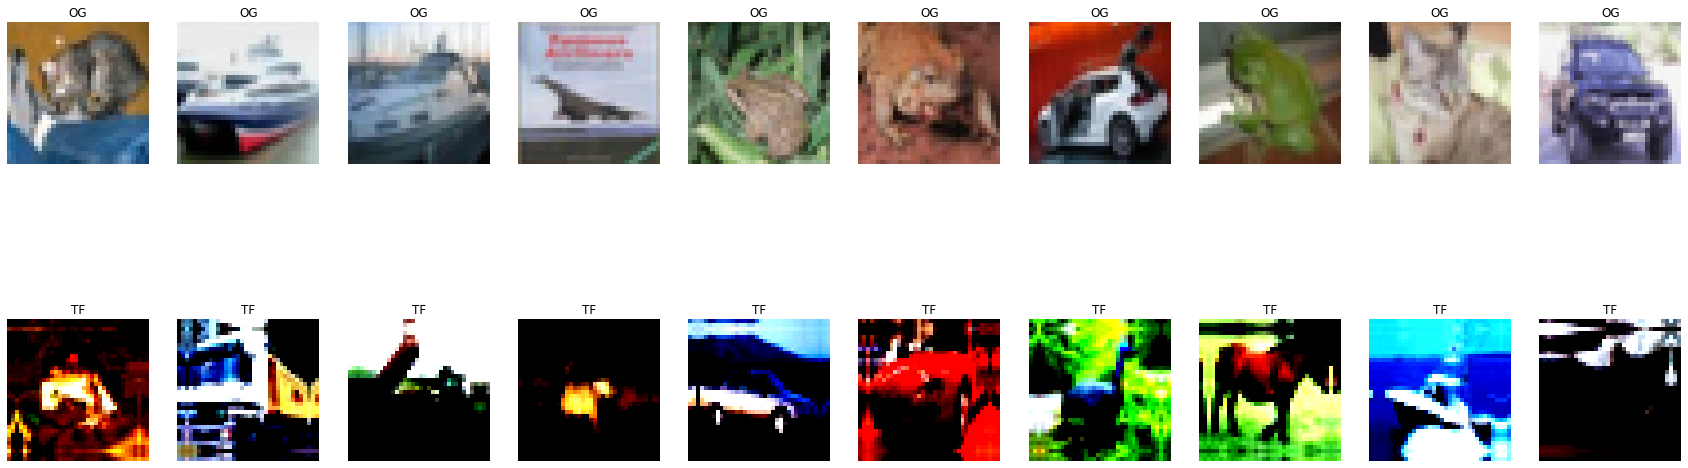

In [6]:
################################
## LOAD DATASET
################################

# datasets
og_dataset = load_cifar10(
    dataset_path=DATASET_PATH, is_train=False, image_transforms=ToTensorV2(),
)

# calculate dataset mean and std
dataset_mean, dataset_std = calc_data_stats(og_dataset)

image_transforms = transforms(dataset_mean, dataset_std)

train_dataset = load_cifar10(
    dataset_path=DATASET_PATH,
    is_train=True,
    image_transforms=image_transforms["train"],
)

test_dataset = load_cifar10(
    dataset_path=DATASET_PATH,
    is_train=False,
    image_transforms=image_transforms["test"],
)


class2idx = class_to_idx(og_dataset.classes)
idx2class = idx_to_class(class2idx)


visualise_transforms(
    original_data=og_dataset, transformed_data=train_dataset, num_samples=10
)

In [7]:
################################
## CREATE DATALOADERS
################################

# dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## Data Sanity Check
print(f"\nTrain loader = {next(iter(train_loader))[0].shape}")
print(f"Val loader = {next(iter(val_loader))[0].shape}")
print(f"Test loader = {next(iter(test_loader))[0].shape}")
print(f"\nTrain loader length = {len(train_loader)}")
print(f"Val loader length = {len(val_loader)}")
print(f"Test loader length = {len(test_loader)}")


Train loader = torch.Size([256, 3, 36, 36])
Val loader = torch.Size([256, 3, 36, 36])
Test loader = torch.Size([256, 3, 32, 32])

Train loader length = 196
Val loader length = 196
Test loader length = 40


In [8]:
################################
## LOAD MODEL
################################

model = SpatialTransformer(num_input_channels=NUM_INPUT_CHANNELS, num_classes=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See 


Recommended LR = 0.1073418882701351 at loss=2.304522300853695


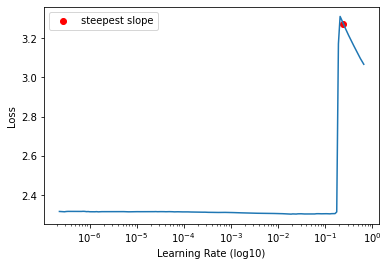

In [9]:
from app.utils.lr_finder import LRFinder

lr_finder = LRFinder(model=model, criterion=criterion, optimizer=optimizer, device=device)
LEARNING_RATE = lr_finder.run(dataloader=train_loader)
lr_finder.plot()

In [10]:
LEARNING_RATE = 0.001
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=round(0.001, 3),
                                          steps_per_epoch=len(train_loader),
                                          epochs=EPOCHS)


Begin training.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Epoch 01/50: | Train Loss: 2.32119 | Val Loss: 2.32085 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 02/50: | Train Loss: 2.32044 | Val Loss: 2.31996 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 03/50: | Train Loss: 2.31937 | Val Loss: 2.31869 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 04/50: | Train Loss: 2.31792 | Val Loss: 2.31707 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 05/50: | Train Loss: 2.31617 | Val Loss: 2.31521 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 06/50: | Train Loss: 2.31426 | Val Loss: 2.31328 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 07/50: | Train Loss: 2.31237 | Val Loss: 2.31143 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 08/50: | Train Loss: 2.31060 | Val Loss: 2.30975 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 09/50: | Train Loss: 2.30903 | Val Loss: 2.30830 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 10/50: | Train Loss: 2.30770 | Val Loss: 2.30709 | Train Acc: 9.949% | Val Acc: 9.949%
Epoch 11/50: | Train Loss: 2.30660 | Val Loss: 2.30610 | Train Acc: 9.

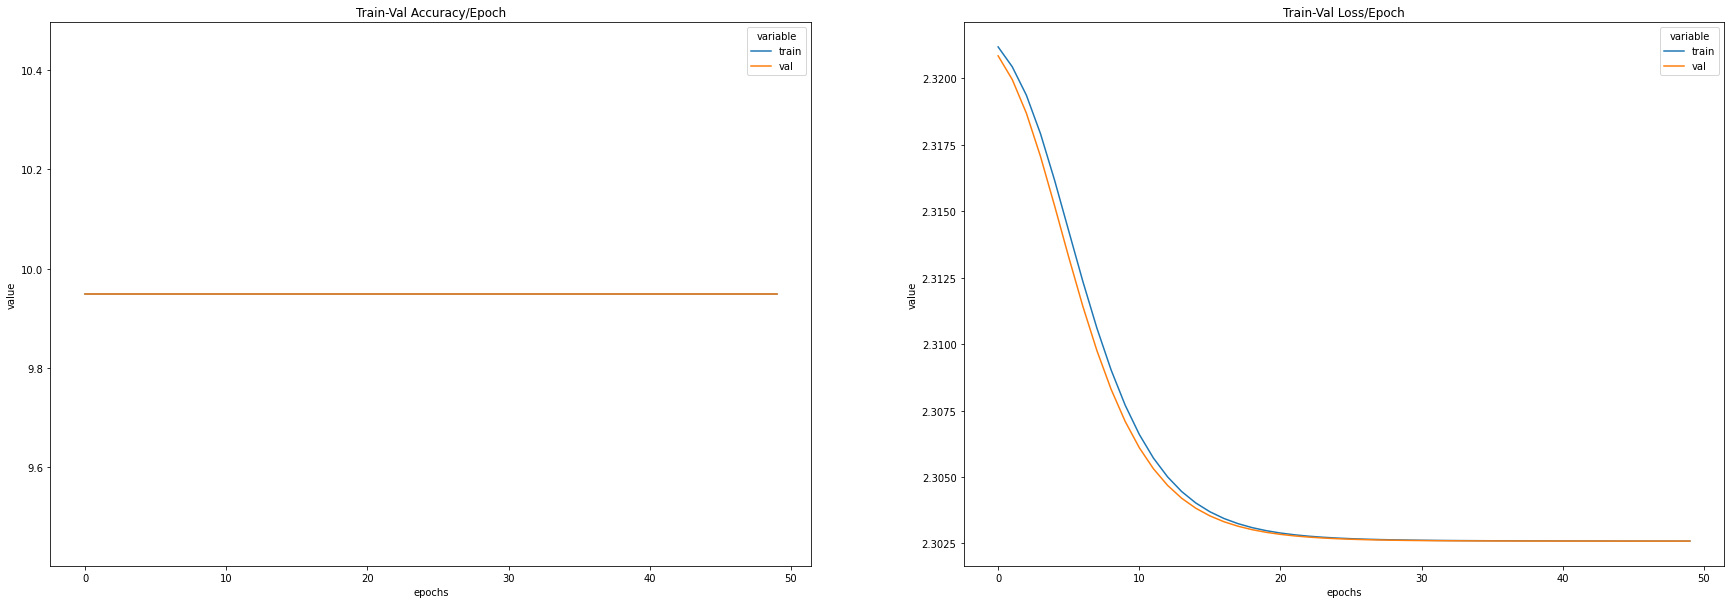

In [11]:
###########################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


loss_acc_curves(loss_stats=loss_stats, acc_stats=acc_stats)

In [12]:
################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)

RuntimeError: ignored

In [ ]:
################################
## Result Stats
################################
print(score_report(y_true_list, y_pred_list, idx2class))

In [ ]:
################################
## Result Analysis
################################

def get_misclassified_info(y_pred_list, y_true_list):
    return [
        {"idx": i, "pred": pred, "true": actual}
        for i, (pred, actual) in enumerate(zip(y_pred_list, y_true_list))
        if pred != actual
    ]


misclassified_info = get_misclassified_info(
    y_pred_list=y_pred_list, y_true_list=y_true_list
)


visualize_misclassified_images(
    misclassified_info=misclassified_info,
    dataset=og_dataset,
    idx_to_class=idx2class,
    num_samples=11,
)

In [ ]:
################################
## GradCAM
################################
x_test, y_test = test_dataset[40]


tensor_to_image(x_test)

In [ ]:
cam = GradCAM(
    model=trained_model, target_layer=trained_model.layer_2.base_layer[-1].base_block[-1][0]
)

output = cam(x_test.to(device))


plt.imshow(output)

In [ ]:
misclassified_gradcam(
    model = trained_model,
    misclassified_info=misclassified_info,
    dataset=test_dataset,
    idx_to_class=idx2class,
    num_samples=10,
    device=device
)